Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization


Step 2: Load and Explore Data

Dataset loaded!
Shape: (29964, 5)

First 5 rows:
            a           b  opcode  faulty_result  fault_type
0   303379748  3230228097       2          70656           0
1  2223298057  2985317987       0      913648748           0
2   112818957  1189058957       2      110696719           1
3  2999092325  2302104082       2     3238658048           1
4    15983361   114806029       4      103034380           0

 Fault Type Distribution:
  No Fault: 11993 samples
  Bitflip: 11964 samples
  Opcode Fault: 6007 samples


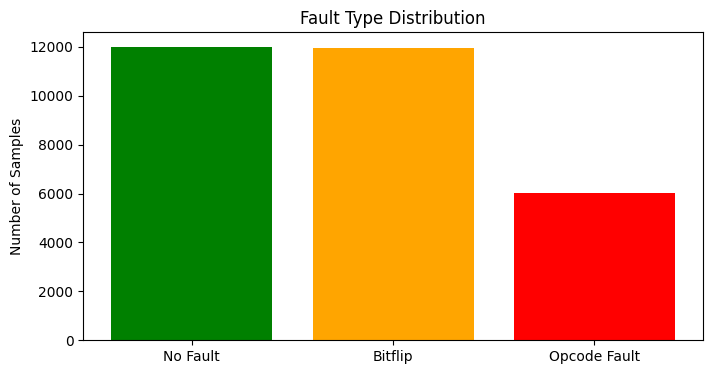

In [2]:
# Load your dataset
df = pd.read_csv("enhanced_dataset_dl.csv")
print("Dataset loaded!")
print(f"Shape: {df.shape}")

# Show first few rows
print("\nFirst 5 rows:")
print(df.head())

# Check fault distribution
print("\n Fault Type Distribution:")
fault_counts = df['fault_type'].value_counts().sort_index()
fault_names = {0: "No Fault", 1: "Bitflip", 2: "Opcode Fault"}

for fault_id, count in fault_counts.items():
    print(f"  {fault_names[fault_id]}: {count} samples")

# Visualize the distribution
plt.figure(figsize=(8, 4))
plt.bar(fault_names.values(), fault_counts.values, color=['green', 'orange', 'red'])
plt.title('Fault Type Distribution')
plt.ylabel('Number of Samples')
plt.show()

Step 3: Prepare Features

In [3]:
print("Preparing features...")

def calculate_correct_result(a, b, opcode):
    """Calculate what the correct ALU result should be"""
    if opcode == 0: return (a + b) & 0xFFFFFFFF  # ADD
    elif opcode == 1: return (a - b) & 0xFFFFFFFF  # SUB
    elif opcode == 2: return a & b  # AND
    elif opcode == 3: return a | b  # OR
    elif opcode == 4: return a ^ b  # XOR
    else: return 0

# Calculate correct results
df['correct_result'] = df.apply(
    lambda row: calculate_correct_result(row['a'], row['b'], row['opcode']), 
    axis=1
)

# Calculate error bits (XOR between faulty and correct result)
df['error_bits'] = df['faulty_result'] ^ df['correct_result']

print(" Features prepared!")
print(f"New columns: {df.columns.tolist()}")

Preparing features...
 Features prepared!
New columns: ['a', 'b', 'opcode', 'faulty_result', 'fault_type', 'correct_result', 'error_bits']


Step 4: Create CNN Input Features

In [4]:
# 1. Define the missing helper function
def error_to_binary(error_int):
    """Convert error integer to 32-bit binary sequence list"""
    # Format as 32-bit binary string (e.g., '000...101')
    binary_str = format(error_int, '032b')
    # Convert string to list of integers [0, 0, ..., 1, 0, 1]
    return [int(bit) for bit in binary_str]

# 2. Define the feature engineering function
def create_enhanced_features(error_bits_col):
    X = []
    for err in error_bits_col:
        # Call the helper function we just defined
        binary = error_to_binary(err)
        bit_count = sum(binary) # Count the 1s (Hamming weight)
        
        # Create 32x2 matrix: [Bit Value, Global Error Count]
        feature = [[b, bit_count] for b in binary] 
        X.append(feature)
    return np.array(X)

print("Helper functions defined successfully!")

Helper functions defined successfully!


In [5]:
# Create feature matrix with 2 channels
# Channel 1: The bit (0 or 1)
# Channel 2: The count of errors (Global context)

def create_enhanced_features(error_bits_col):
    X = []
    for err in error_bits_col:
        binary = error_to_binary(err)
        bit_count = sum(binary) # How many bits are wrong?
        
        # Create 32x2 matrix
        # Col 1 is the bit sequence
        # Col 2 is the count repeated (giving context to every node)
        feature = [[b, bit_count] for b in binary] 
        X.append(feature)
    return np.array(X)

X_bits = create_enhanced_features(df['error_bits'])
# New Input Shape will be (samples, 32, 2)

Step 5: Split Data and Prepare for CNN

In [6]:
# 1. Define 'y' (the target/label) from your dataframe
# This assumes your dataframe is named 'df' and the target column is 'fault_type'
y = df['fault_type']

print(f"Labels 'y' defined with shape: {y.shape}")

# 2. Now run the split and reshape code
print("Splitting data...")

X_train, X_test, y_train, y_test = train_test_split(
    X_bits, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

# 3. Reshape for the 2-channel CNN
# (samples, 32 time steps, 2 features)
X_train_cnn = X_train.reshape(X_train.shape[0], 32, 2)
X_test_cnn = X_test.reshape(X_test.shape[0], 32, 2)

print(f"Data prepared!")
print(f"Training shape: {X_train_cnn.shape}")
print(f"Testing shape: {X_test_cnn.shape}")

Labels 'y' defined with shape: (29964,)
Splitting data...
Data prepared!
Training shape: (23971, 32, 2)
Testing shape: (5993, 32, 2)


Step 6: Build Simple CNN Model

In [7]:
# Step 6: Re-Build Model with Updated Input Shape
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, BatchNormalization

print(" Re-building CNN model for 2-channel input...")

model = Sequential([
    # Update input_shape to (32, 2) to match your new X_train data
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(32, 2)),
    BatchNormalization(),
    
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    
    # Feature extraction specific to single bits
    Conv1D(filters=64, kernel_size=1, activation='relu'),
    
    Flatten(),
    
    Dense(64, activation='relu'),
    # Output layer
    Dense(3, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model updated")
model.summary()

 Re-building CNN model for 2-channel input...
Model updated


d:\python_extra\mini_project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 32, 32)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 32, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,307 (555.89 KB)

 Trainable params: 142,115 (555.14 KB)

 Non-trainable params: 192 (768.00 B)

Step 7: Train the Model

In [8]:
print("Training model...")

# Stop training if validation loss doesn't improve
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print(" Training completed!")

Training model...
Epoch 1/50


750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9890 - loss: 0.0525 - val_accuracy: 0.9965 - val_loss: 0.0256
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9945 - loss: 0.0308 - val_accuracy: 0.9957 - val_loss: 0.0256
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9945 - loss: 0.0315 - val_accuracy: 0.9938 - val_loss: 0.0464
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9952 - loss: 0.0263 - val_accuracy: 0.9972 - val_loss: 0.0184
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9932 - loss: 0.0396 - val_accuracy: 0.9965 - val_loss: 0.0259
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9952 - loss: 0.0274 - val_accuracy: 0.9972 - val_loss: 0.0174
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9955 - loss: 0.0249 - val_accuracy: 0.9972 - val_loss: 0.0198
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9962 - loss: 0.0225 - val_accuracy: 0.9972 - val_

Step 8: Evaluate Model Performance

Evaluating model...
Test Accuracy: 99.72%


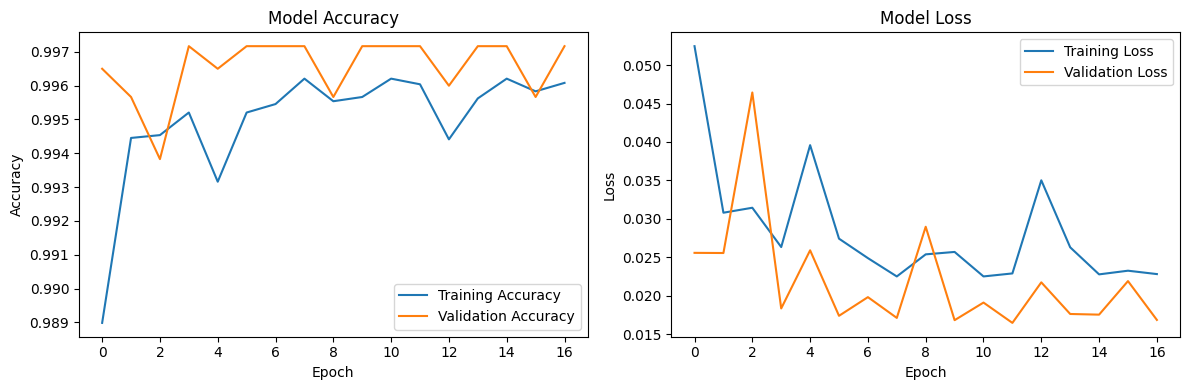

In [9]:
print("Evaluating model...")

# Test accuracy
test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Step 9: Detailed Performance Analysis

 Detailed performance analysis...
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


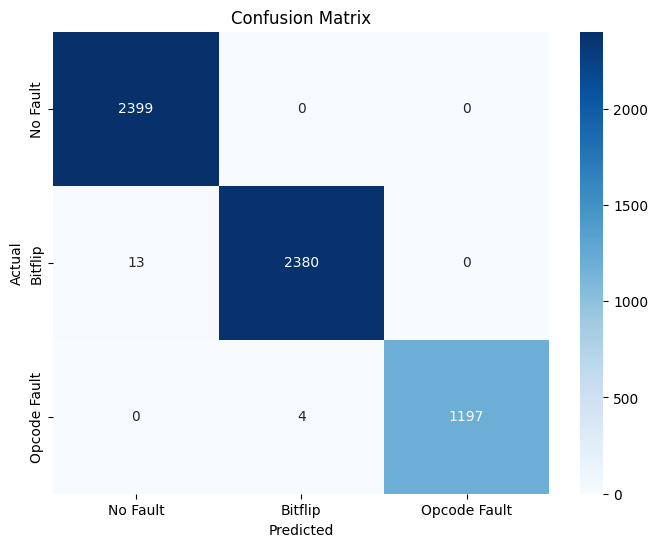


 Classification Report:
              precision    recall  f1-score   support

    No Fault       0.99      1.00      1.00      2399
     Bitflip       1.00      0.99      1.00      2393
Opcode Fault       1.00      1.00      1.00      1201

    accuracy                           1.00      5993
   macro avg       1.00      1.00      1.00      5993
weighted avg       1.00      1.00      1.00      5993



In [10]:
print(" Detailed performance analysis...")

# Make predictions
y_pred = np.argmax(model.predict(X_test_cnn), axis=1)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fault', 'Bitflip', 'Opcode Fault'],
            yticklabels=['No Fault', 'Bitflip', 'Opcode Fault'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("\n Classification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['No Fault', 'Bitflip', 'Opcode Fault']))

Step 10: Test with Custom Examples

In [11]:
print("Testing with custom examples...")

def predict_fault(a, b, opcode, faulty_result):
    """Predict fault type for custom inputs using Enhanced Features"""
    # 1. Calculate correct result
    correct = calculate_correct_result(a, b, opcode)
    
    # 2. Calculate error bits
    error_bits = faulty_result ^ correct
    
    # 3. Convert to binary sequence
    binary_sequence = error_to_binary(error_bits)
    
    # 4. Create 2-Channel Input (Bit + Bit Count)
    # This matches exactly what we did for X_train
    bit_count = sum(binary_sequence)
    feature = [[bit, bit_count] for bit in binary_sequence]
    
    # Reshape to (1 sample, 32 steps, 2 channels)
    X_input = np.array(feature).reshape(1, 32, 2)
    
    # 5. Make prediction
    prediction = model.predict(X_input, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class] * 100
    
    return fault_names[predicted_class], confidence

# Test cases
test_cases = [
    (100, 200, 0, 300),    # No fault expected
    (100, 200, 0, 1324),   # Bitflip expected  
    (500, 150, 1, 503),    # Opcode fault expected
    (100, 200, 0, 301)     # Small Bitflip (LSB) - The hard one!
]

print("\nCustom Test Results:")
for i, (a, b, opcode, faulty) in enumerate(test_cases):
    fault_type, confidence = predict_fault(a, b, opcode, faulty)
    print(f"Test {i+1}: A={a}, B={b}, Opcode={opcode}, Faulty={faulty}")
    print(f"  → Predicted: {fault_type} ({confidence:.1f}% confidence)")
    print()

Testing with custom examples...

Custom Test Results:
Test 1: A=100, B=200, Opcode=0, Faulty=300
  → Predicted: No Fault (99.7% confidence)

Test 2: A=100, B=200, Opcode=0, Faulty=1324
  → Predicted: Bitflip (100.0% confidence)

Test 3: A=500, B=150, Opcode=1, Faulty=503
  → Predicted: Opcode Fault (99.5% confidence)

Test 4: A=100, B=200, Opcode=0, Faulty=301
  → Predicted: Bitflip (100.0% confidence)



Step 11: Save the Model

In [12]:
print(" Saving model...")

# The modern standard (TensorFlow 2.10+)
model.save('cnn_model.keras') 

print(" Model saved as 'cnn_model.keras'")

 Saving model...
 Model saved as 'cnn_model.keras'
